# Complementarity and Optimal Stopping

- Prof. Jesse Perla, (jesse.perla@ubc.ca)
- Arnav Sood (arnav.sood@ubc.ca)

The goal of this notebook is to illustrate and compare different Julia approaches to solving [optimal stopping problems](https://en.wikipedia.org/wiki/Optimal_stopping).

In particular, we will be examining reformulations of these problems as [linear complementarity problems](https://en.wikipedia.org/wiki/Linear_complementarity_problem).

### Introduction to Optimal Stopping

----------

Optimal stopping problems concern a decision of when to exit some process and "accept" the current realization of some state variable. Many option problems (e.g., when to exercise a stock option at a current price, when to hire a worker at a current quality, etc.) take this form.


An familiar example for economists is the [McCall job-search model](https://en.wikipedia.org/wiki/Secretary_problem), whose central question ("when, in terms of the offer received, should I stop looking for a job?") is essentially the same thing.

### Vanilla (Bellman) Formulation (Continuous-Time, 1D)

-----------

The standard approach (as described by, e.g. [Stokey and Lucas](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf)) is to write down a recursive problem.

Here's the value function:

$$ 
\begin{align}v(x) &= \max_{\tau \geq 0} \mathbb{E}_0 \big\{ e^{-\rho t} u(x_t)d_t + e^{-\rho \tau}S(x_\tau) \big\} \\ 
dx_t &= \mu(x_t) + \sigma(x_t)dW_t
\end{align}$$

In this setup:

- $\rho$ is the discount rate
- $x_t$ is the current state
- $W_t$ is some random shock, like a white noise process
- $\mu(x_t)$ is the **state-dependent** drift of the state
- $\sigma(x_t)$ is the **state-dependent** loading on the shock
- $u(x_t)$ is the instantaneous flow utility under the optimal policy
- $S(x_\tau)$ is the **state-dependent** value of stopping (i.e., think of this as "exiting" a search with the current realization of some state variable)

The traditional next step is to write a Bellman equation (or, more precisely in the continuous-time case, a Hamilton-Jacobi-Bellman equation):

$$ \rho v(x) = u(x) + \mu(x) v'(x) + \frac{\sigma^2(x)}{2} v''(x) $$

We can then solve this problem (after choosing a discrete grid of points) by iterating to a fixed point.

Let's set up some primitives.

In [46]:
using Parameters, LinearAlgebra, Distributions

# generator for stopping problem with default values 
StoppingProblem = @with_kw (ρ = 0.05, # discount rate
                            μ = x -> -0.01 * x, # drift
                            σ = x -> 0.05 * x, # volatility
                            u = x -> x^(1/2), # flow utility
                            S = x -> 20. - 0.01 * x, # stopping value
                            W = Normal(0.0, 0.01), # shock
                            x_min = 0.0,
                            x_max = 10.0,
                            M = 300) # number of grid points

#72 (generic function with 2 methods)

To use this generator:

In [47]:
default_problem = StoppingProblem();
@show default_problem.M; # should be 300

default_problem.M = 300


In [48]:
new_problem = StoppingProblem(M = 400, ρ = 0.02);
@show new_problem.M, new_problem.ρ, new_problem.μ(1); # should be 400, 0.02, -0.1 

(new_problem.M, new_problem.ρ, new_problem.μ(1)) = (400, 0.02, -0.01)


So, parameters we explicitly change use the new values, and everything else uses the defaults.

### Stuff from Before

-------



In [49]:
# Diffusion operators with regular grids
function diffusionoperators(x::AbstractRange) # ξ = 0.0 corresponds to the unrescaled case from PTW
    Δ = step(x)
    P = length(x)

    dl_1 = zeros(P-1)
    d_1 = -ones(P)
    du_1 = ones(P-1)
    d_1[end] = d_1[end] + du_1[end] 
    L_1_plus = Tridiagonal(dl_1, d_1, du_1)/Δ

    dl_m1 = -ones(P-1)
    d_m1 = ones(P)
    du_m1 = zeros(P-1)
    d_m1[1] = d_m1[1] + dl_m1[1] 
    L_1_minus = Tridiagonal(dl_m1, d_m1, du_m1)/Δ

    dl_2 = ones(P-1)
    d_2 = -2 * ones(P)
    d_2[1] = -1
    d_2[end] = -1
    du_2 = ones(P-1)
    L_2 = Tridiagonal(dl_2, d_2, du_2)/(Δ^2)

    return (L_1_minus, L_1_plus, L_2)
end

diffusionoperators (generic function with 1 method)

In [50]:
function LCP_objects(sp)
    # setup work 
    @unpack ρ, μ, σ, S, W, x_min, x_max, M, W, u = sp 
    grid = range(x_min, x_max, length = M) # instantiate grid 
    L_1_minus, L_1_plus, L_2 = diffusionoperators(grid)
    A = Diagonal(μ.(grid)) * L_1_minus + 1/2 * Diagonal(σ.(grid))^2 * L_2 
    B = ρ*I - A 
    S_vec = S.(grid)
    q = -u.(grid) + B*S_vec 
    return (A = A, B = B, S = S_vec, q = q)
end

LCP_objects (generic function with 1 method)

In [51]:
A, B, S, q = LCP_objects(default_problem);

In [52]:
using PATHSolver

In [53]:
f = z -> B*z + q
n = default_problem.M
lb = zeros(n)
ub = 1000*ones(n) # a reasonable guess?
options(output = :no, time_limit = 600) # 10 minute budget
@time exit_code, sol_z, sol_f = solveLCP(f, lb, ub)

  0.283578 seconds (784.73 k allocations: 41.943 MiB, 7.80% gc time)
Reading options file path.opt
Read of options file complete.

300 row/cols, 897 non-zeros, 1.00% dense.

Path 4.7.03 (Thu Jan 24 15:44:12 2013)
Written by Todd Munson, Steven Dirkse, and Michael Ferris

 ** EXIT - solution found.


(:Solved, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  34.803, 34.8324, 34.8589, 34.8825, 34.9031, 34.9206, 34.9349, 34.9458, 34.9533, 34.9573], [1.0, 0.817101, 0.74133, 0.683184, 0.634161, 0.590969, 0.551919, 0.516007, 0.482579, 0.451182  …  2.30926e-14, -5.68878e-13, 7.16316e-13, -4.14779e-13, -8.81073e-13, -9.34364e-13, 6.72351e-13, -2.40252e-13, 1.69909e-12, -8.32667e-13])

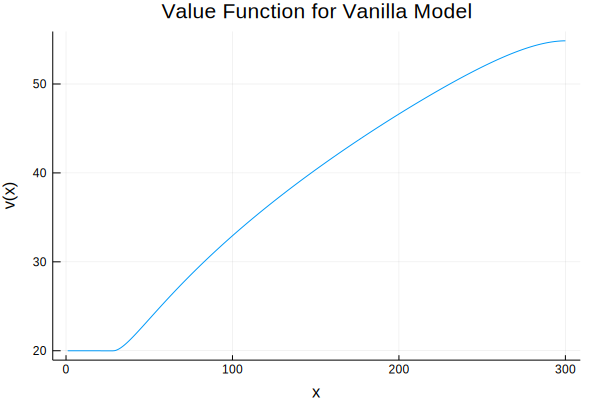

In [54]:
using Plots
v = sol_z + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

In [55]:
using NLsolve

In [56]:
function f!(F, z)
    F .= B*z + q # in place assignment
end

@time r = mcpsolve(f!, lb, ub,
                zeros(n), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                ftol = 1e-12);

  4.466888 seconds (12.39 M allocations: 670.624 MiB, 9.50% gc time)


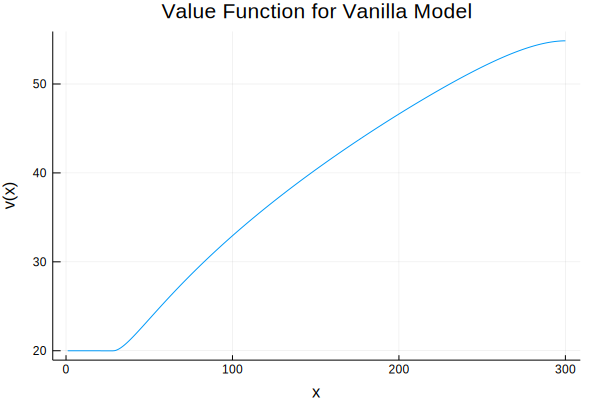

In [57]:
v = r.zero + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

## TBD

------

- upwind scheme
- 1D LCP (NLsolve, PATHSolver)
- Should really get some JuMP in there...
- Multiple dimensions
- Discretization
- probably simulate the process